<a href="https://colab.research.google.com/github/orbitalkinesis/Data-Architect/blob/main/architect_moodboard_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Architectural Moodboard Generator
### AI‑Powered Concept Design Assistant for Architects & Interior Designers

###Upload a floor plan or design brief → generate palettes, materials, lighting moods, precedent images, and a ready‑to‑export moodboard.
"""

'\n# Architectural Moodboard Generator\n### AI‑Powered Concept Design Assistant for Architects & Interior Designers\n\n###Upload a floor plan or design brief → generate palettes, materials, lighting moods, precedent images, and a ready‑to‑export moodboard.\n'

In [ ]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from google.colab import files

from colorthief import ColorThief
from sentence_transformers import SentenceTransformer, util

In [ ]:
# 2. Upload Your Inputs

print("Upload a floor plan or reference image (optional).")
uploaded = files.upload()

design_brief = input("Enter your design brief (e.g. 'warm minimalist apartment with natural light'): ")

img = None
if uploaded:
    # Take the first uploaded file
    fn = list(uploaded.keys())[0]
    img = Image.open(io.BytesIO(uploaded[fn])).convert("RGB")
    print(f"Loaded image: {fn}")
else:
    print("No image uploaded. The notebook will rely on the text brief only.")

Upload a floor plan or reference image (optional).


Saving floor-plan-sample-3.webp to floor-plan-sample-3 (1).webp
Enter your design brief (e.g. 'warm minimalist apartment with natural light'): warm minimalist with natural light
Loaded image: floor-plan-sample-3 (1).webp


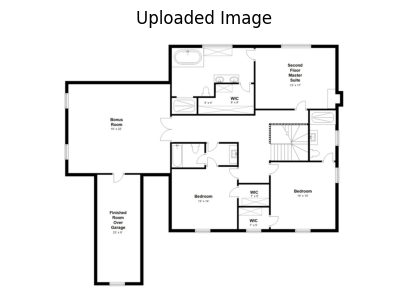

In [ ]:
# 3. Image Preprocessing

if img is not None:
    # Resize for consistency
    max_size = 1024
    w, h = img.size
    scale = min(max_size / w, max_size / h, 1.0)
    new_size = (int(w * scale), int(h * scale))
    img = img.resize(new_size, Image.LANCZOS)

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()
else:
    print("Skipping image preprocessing (no image).")

In [ ]:
# 4. Style Detection

print("Loading CLIP model (SentenceTransformer)...")
model = SentenceTransformer('clip-ViT-B-32')

styles = [
    "minimalist", "scandinavian", "industrial", "brutalist",
    "japandi", "mid-century modern", "contemporary", "organic modern"
]

# Encode brief
brief_text = design_brief if design_brief.strip() else "minimalist architecture"
brief_emb = model.encode(brief_text, convert_to_tensor=True)

# Encode style labels
style_embs = model.encode(styles, convert_to_tensor=True)

scores = util.cos_sim(brief_emb, style_embs)[0].cpu().numpy()
ranked = sorted(zip(styles, scores), key=lambda x: x[1], reverse=True)
top_styles = ranked[:3]

print("\nDetected styles (from brief):")
for s, sc in top_styles:
    print(f"- {s} (score: {sc:.3f})")

primary_style = top_styles[0][0]

Loading CLIP model (SentenceTransformer)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: /root/.cache/huggingface/hub/models--sentence-transformers--clip-ViT-B-32/snapshots/327ab6726d33c0e22f920c83f2ff9e4bd38ca37f/0_CLIPModel
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 



Detected styles (from brief):
- minimalist (score: 0.858)
- organic modern (score: 0.818)
- contemporary (score: 0.806)



Extracted / Generated Palette (RGB):
[(232, 232, 232), (168, 168, 168), (11, 11, 11), (107, 107, 107), (124, 124, 124)]


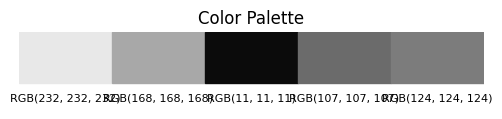

In [ ]:
# 5. Color Palette

def extract_palette_from_image(pil_img, color_count=5):
    pil_img.save("temp_palette.jpg")
    ct = ColorThief("temp_palette.jpg")
    palette = ct.get_palette(color_count=color_count)
    return palette

def display_palette(palette):
    fig, ax = plt.subplots(1, figsize=(6, 1))
    for i, color in enumerate(palette):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=np.array(color)/255.0))
        ax.text(i + 0.5, -0.2, f"RGB{color}", ha="center", va="top", fontsize=8)
    ax.set_xlim(0, len(palette))
    ax.set_ylim(-0.5, 1)
    ax.axis("off")
    plt.title("Color Palette")
    plt.show()

if img is not None:
    palette = extract_palette_from_image(img, color_count=5)
else:
    # Simple fallback palette based on style
    fallback_palettes = {
        "scandinavian": [(230, 230, 225), (210, 200, 190), (180, 170, 160), (140, 140, 135), (110, 110, 105)],
        "industrial":   [(60, 60, 60), (120, 110, 100), (160, 150, 140), (200, 190, 180), (230, 225, 220)],
        "minimalist":   [(245, 245, 245), (220, 220, 220), (190, 190, 190), (150, 150, 150), (100, 100, 100)]
    }
    palette = fallback_palettes.get(primary_style, fallback_palettes["minimalist"])

print("\nExtracted / Generated Palette (RGB):")
print(palette)
display_palette(palette)

In [ ]:
# 6. Material Suggestions

material_library = {
    "scandinavian": [
        "Light oak flooring",
        "Birch plywood cabinetry",
        "White plaster walls",
        "Natural linen textiles"
    ],
    "industrial": [
        "Exposed concrete walls",
        "Blackened steel frames",
        "Weathered brick",
        "Charcoal fabric upholstery"
    ],
    "minimalist": [
        "Smooth white gypsum walls",
        "Matte concrete floor",
        "Bleached wood accents",
        "Clear glass partitions"
    ],
    "brutalist": [
        "Board-formed concrete",
        "Raw steel details",
        "Dark timber",
        "Textured plaster"
    ],
    "japandi": [
        "Warm oak",
        "Tatami-like woven textures",
        "Soft white plaster",
        "Muted stone tiles"
    ],
    "mid-century modern": [
        "Walnut veneer",
        "Terrazzo flooring",
        "Colored laminate panels",
        "Brushed brass details"
    ],
    "contemporary": [
        "Large-format porcelain tiles",
        "Matte black fixtures",
        "Neutral painted walls",
        "Engineered wood flooring"
    ],
    "organic modern": [
        "Natural stone slabs",
        "Rattan and cane",
        "Clay plaster",
        "Warm-toned timber"
    ]
}

materials = material_library.get(primary_style, material_library["minimalist"])

print(f"\nPrimary style: {primary_style}")
print("Suggested materials:")
for m in materials:
    print(f"- {m}")


Primary style: minimalist
Suggested materials:
- Smooth white gypsum walls
- Matte concrete floor
- Bleached wood accents
- Clear glass partitions


In [ ]:
# 7. Lighting Mood

lighting_library = {
    "scandinavian": "Soft daylight emphasis, 3000–3500K, diffused pendants, large windows, light-reflective surfaces.",
    "industrial":   "Cool white 4000–4500K, exposed bulbs, track lighting, accent on raw textures.",
    "minimalist":   "Neutral 3500K, hidden LED strips, indirect cove lighting, minimal fixtures.",
    "brutalist":    "Neutral to cool 3500–4000K, focused beams, dramatic contrast on concrete surfaces.",
    "japandi":      "Warm 2700–3000K, low-level lamps, paper lanterns, gentle layered lighting.",
    "mid-century modern": "Warm 2700–3000K, statement pendants, sculptural floor lamps.",
    "contemporary": "Neutral 3500K, recessed downlights, linear LEDs, accent lighting on key surfaces.",
    "organic modern": "Warm 2700–3000K, soft indirect lighting, emphasis on natural textures."
}

lighting_mood = lighting_library.get(primary_style, lighting_library["minimalist"])

print("\nLighting mood suggestion:")
print(lighting_mood)


Lighting mood suggestion:
Neutral 3500K, hidden LED strips, indirect cove lighting, minimal fixtures.


In [ ]:
# 8. Precedent Images (Placeholder)

# If you want to integrate Stable Diffusion, you would do it here.
# For now, we'll just show a text message and skip actual generation.

generate_precedents = False  # set True when you wire in a model

precedent_images = []

if generate_precedents:
    print("Generating precedent images with Stable Diffusion (not implemented in this stub).")
else:
    print("\nPrecedent image generation is currently disabled (placeholder).")
    print("You can integrate Stable Diffusion here for real AI images.")


Precedent image generation is currently disabled (placeholder).
You can integrate Stable Diffusion here for real AI images.


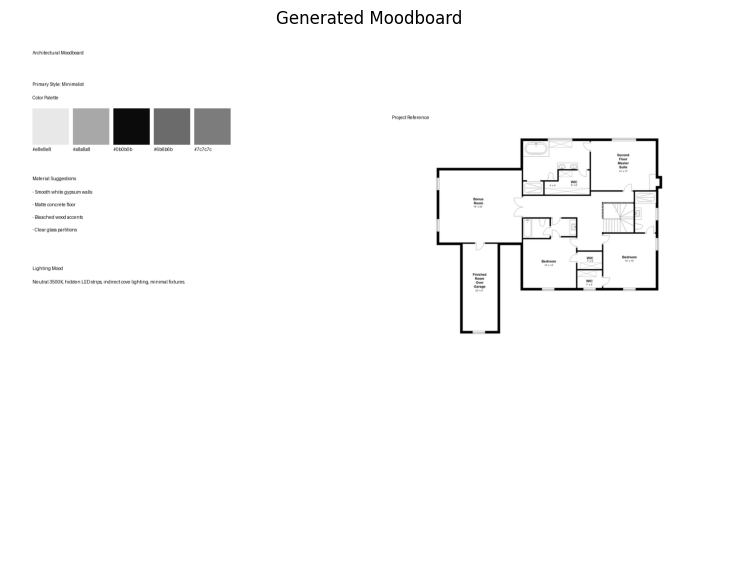

Saved moodboard as moodboard.png


In [ ]:
# 9. Moodboard Assembly

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

# Canvas settings
canvas_w, canvas_h = 1600, 1200
canvas = Image.new("RGB", (canvas_w, canvas_h), "white")
draw = ImageDraw.Draw(canvas)

# Try to load a default font
try:
    font_title = ImageFont.truetype("DejaVuSans-Bold.ttf", 40)
    font_body = ImageFont.truetype("DejaVuSans.ttf", 24)
    font_small = ImageFont.truetype("DejaVuSans.ttf", 18)
except:
    font_title = font_body = font_small = ImageFont.load_default()

# Title
title_text = "Architectural Moodboard"
draw.text((50, 40), title_text, fill=(0,0,0), font=font_title)

# Style text
style_text = f"Primary Style: {primary_style.capitalize()}"
draw.text((50, 110), style_text, fill=(0,0,0), font=font_body)

# Palette block
palette_x, palette_y = 50, 170
swatch_w, swatch_h = 80, 80
for i, color in enumerate(palette):
    x0 = palette_x + i * (swatch_w + 10)
    y0 = palette_y
    x1 = x0 + swatch_w
    y1 = y0 + swatch_h
    draw.rectangle([x0, y0, x1, y1], fill=color)
    hex_text = rgb_to_hex(color)
    draw.text((x0, y1 + 5), hex_text, fill=(0,0,0), font=font_small)

draw.text((palette_x, palette_y - 30), "Color Palette", fill=(0,0,0), font=font_body)

# Materials block
materials_x, materials_y = 50, 350
draw.text((materials_x, materials_y - 30), "Material Suggestions", fill=(0,0,0), font=font_body)
line_y = materials_y
for m in materials:
    draw.text((materials_x, line_y), f"- {m}", fill=(0,0,0), font=font_small)
    line_y += 28

# Lighting block
lighting_x, lighting_y = 50, 550
draw.text((lighting_x, lighting_y - 30), "Lighting Mood", fill=(0,0,0), font=font_body)
draw.multiline_text((lighting_x, lighting_y), lighting_mood, fill=(0,0,0), font=font_small, spacing=4)

# Image area (if uploaded)
if img is not None:
    # Fit image into a box on the right
    box_w, box_h = 700, 500
    img_copy = img.copy()
    img_copy.thumbnail((box_w, box_h), Image.LANCZOS)
    img_w, img_h = img_copy.size
    img_x = canvas_w - box_w - 50 + (box_w - img_w)//2
    img_y = 200 + (box_h - img_h)//2
    canvas.paste(img_copy, (img_x, img_y))
    draw.text((img_x, img_y - 30), "Project Reference", fill=(0,0,0), font=font_body)
else:
    draw.text((canvas_w - 700, 350), "No reference image provided.", fill=(150,150,150), font=font_body)

plt.figure(figsize=(10,7))
plt.imshow(canvas)
plt.axis("off")
plt.title("Generated Moodboard")
plt.show()

canvas.save("moodboard.png")
print("Saved moodboard as moodboard.png")

In [ ]:
# 10. Design Narrative

primary_materials = ", ".join(materials[:2])

narrative = f"""
This concept embraces {primary_style} principles, using {primary_materials}
to create a calm, coherent spatial atmosphere. The palette is drawn from
the selected tones, balancing light and shadow to support the architectural intent.
Lighting is planned as: {lighting_mood}
"""

print("Design Narrative:\n")
print(narrative)

with open("design_narrative.txt", "w") as f:
    f.write(narrative)

print("\nSaved narrative as design_narrative.txt")

Design Narrative:


This concept embraces minimalist principles, using Smooth white gypsum walls, Matte concrete floor 
to create a calm, coherent spatial atmosphere. The palette is drawn from 
the selected tones, balancing light and shadow to support the architectural intent. 
Lighting is planned as: Neutral 3500K, hidden LED strips, indirect cove lighting, minimal fixtures.


Saved narrative as design_narrative.txt


In [ ]:
# 11. Export

print("Click to download your files:")
files.download("moodboard.png")
files.download("design_narrative.txt")

Click to download your files:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>